# Assignment 3: Text Classification and Word Embeddings

Due: Monday, January 23, 2023, at 2pm via Moodle

**Team Members** Clemes Langer, Levi Szamek, Daniel Abanto Graffman

### Submission Guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will see that this notebook contains some pre-filled cells that you should complete for the individual tasks.
- For answers requiring written solutions, use Markdown cells (in combination with Jupyter LaTeX support) **inside this notebook**. Do *not* hand in any separate files, simply re-upload the `.ipynb` file.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- Make sure that the names of all team members are present in the solution (see cell above).

In [47]:
%%python "--version"
# check requirements


Python 3.10.9


In [48]:
# Install necessary packages
%pip install "-r" requirements.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 10.1 MB/s eta 0:00:0000:0100:01
  Using cached FuzzyTM-2.0.5-py3-none-any.whl (29 kB)
  Using cached pyFUME-0.2.25-py3-none-any.whl (67 kB)


  Using cached simpful-2.9.0-py3-none-any.whl (30 kB)
  Using cached fst-pso-1.8.1.tar.gz (18 kB)
  Preparing metadata (setup.py) ... done
  Using cached miniful-0.0.6.tar.gz (2.8 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20430 sha256=7addd9ac206398fefc531a4809ba5d182f4c4603ddb2dbd56fd898cf9e210c36
  Stored in directory: /Users/dabanto/Library/Caches/pip/wheels/01/02/ee/df0699282986903a384b69aab4413af9efd26b3612b5dccc9e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3513 sha256=c279e867bc6845a9cd3de669b4ec20814f2ab28f838cd4d3bf20f08ddd78c158
  Stored in directory: /Users/dabanto/Library/Caches/pip/wheels/43/aa/48/5c66b931ff013ad19774081aa19656637af5c0cc33b5494b30
Successfully built fst-pso miniful
Note: you may need to restart the kernel to use updated packages.


In [49]:
%%python "-m" spacy download en_core_web_sm
# Install required language model for spaCy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Task 1: F.R.I.E.N.D.S and  Word2Vec (6 + 8 + 4 = 18 Points)

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this problem set we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

In [50]:
import re  
import pandas as pd  
from collections import defaultdict  
import spacy 
import logging
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import numpy as np
import seaborn as sns
import sys
from sklearn.manifold import TSNE
from typing import Type
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Pre-processing (6 Points)

We start by loading and cleaning the data. The dataset for this problem set can be found in the attached `data` folder. Load the `friends_quotes.csv` file using pandas. The dataset is from [Kaggle](https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that can determine which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains the line from the movie and `author` is the one who spoke it. Since these are the only two columns we need, we remove the rest and only keep these two. 

In [ ]:
# setting up logging to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= "%H:%M:%S", level=logging.INFO)

In [51]:
df = pd.read_csv("data/friends_quotes.csv")
df = df.drop(["episode_number","episode_title","quote_order","season"],axis=1)
df.head(10)

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
5,Monica,"Okay, everybody relax. This is not even a date..."
6,Chandler,Sounds like a date to me.
7,Chandler,"Alright, so I'm back in high school, I'm stand..."
8,All,"Oh, yeah. Had that dream."
9,Chandler,"Then I look down, and I realize there's a phon..."


Fortunately, there is no missing data, so we do not need to worry about that. 

In [52]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

Use SpaCy similar to assignment 2 to pre-process the text and perform the following steps: 
- lowercase the words 
- remove stopwords and single characters
- use regex to remove non-alphabetic characters; in other words: only keep "a" to "z" and digits. 
- remove lines that have less than 3 words, since they cannot contribute much to the training process.

Please do not add additional steps on your own or additional cleaning as we want to create comparable results. 

In [53]:
from gensim.parsing.preprocessing import remove_stopwords
import re

def clean(quote:str):
    try:
        quote = quote.lower()
        quote = remove_stopwords(quote,stopwords)
        quote = re.sub('[^A-Za-z0-9 ]+', '', quote)
        #print(quote)
        if len(quote.split(" ")) > 3:
            return quote 
        else:
            return None
    except:
        return quote
    

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "lemmatizer"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS # only use these stop words, do not add your own!
df["quote"] =  df["quote"].apply(clean)# lowercase and remove non-alphabetic characters
df = df.dropna(subset=["quote"])
quotes = df[df["quote"]!=None]["quote"].to_list()


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, to keep the computation time-limited.

In [54]:
from gensim.models import Phrases
from gensim.parsing.preprocessing import preprocess_documents

words = [i.split(" ") for i in quotes]
phrases = Phrases(words,min_count=10)
bigrams = Phraser(phrases)

sententces = bigrams[words]

word_freq = defaultdict(int)
for sentence in sententces:
    for word in sentence:
        word_freq[word] += 1
sorted_words = sorted(word_freq, key=word_freq.get, reverse=True)
vocab = sorted_words[:15000]



#words = [[w for w in ws if w in vocab] for ws in words]
#sentences = bigrams[words]

In [55]:
### find the top words for the vocabulary###

vocab = sorted_words[:15000]


### 2. Training (8 Points)

Use the Gensim implementation of Word2Vec to train a model on the quotes. The training can be divided into 3 stages:

1. Set up and configure your model. Define the parameters in such a way that the following conditions are satisfied:
    - Ignores all words that have a total absolute frequency less than 2
    - Dimensions of the embeddings: 100 
    - Initial learning rate of 0.03 
    - 20 negative samples 
    - Window size 3 
    - The learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
    - Set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
    - Set the hashfunction of the word2vec to the given function.
    - Train on a single worker to make sure you get the same result as ours.

In [56]:
def hash(astring):
    return ord(astring[0])


w2v = Word2Vec(min_count=2,window=3,vector_size=100,alpha=0.03,negative=20,min_alpha=0.0001,hashfxn=hash,sample=0.00006)

2. Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus. Use the `build_vocab` function to process the data.

In [57]:
w2v.build_vocab(sententces)

3. Finally, we get to train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis. 

In [58]:
w2v.train(sententces,total_examples=w2v.corpus_count,epochs=100)

(14692287, 32381500)

In [59]:
w2v.init_sims(replace=True)

/var/folders/8z/krlt9xcn6kxcp2k7w1_7ts3h0000gn/T/ipykernel_8241/2512947105.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


### 3. Exploration (4 Points)

As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset: 

We look for the most similar words to the famous coffee shop where most of the episodes took place, namely `central_perk` and also for the ones similar to the character `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.

In [60]:
w2v.wv.most_similar(positive=["central_perk"]) # i think this is due to the fact that i ve used the complete list instead of the top 15000 words

[('conan', 0.6048544049263),
 ('itscene', 0.5801846981048584),
 ('sitting_couch', 0.5576051473617554),
 ('aaah', 0.48515427112579346),
 ('mitzi', 0.48172420263290405),
 ('laptop', 0.3910677433013916),
 ('enters', 0.3841283321380615),
 ('nearby', 0.3835323452949524),
 ('barking', 0.3815099895000458),
 ('couch', 0.36678025126457214)]

In [ ]:
w2v.wv.most_similar(positive=["joey"]) 

Look at the similarity of `mrs_green` to `rachel` (her mom) and `ross`  to `spaceship` (unrelated). The first one should have a high score whereas the second should have a low score. Finally look at the similarity of `smelly_cat` (a song from pheobe) and `song`, which should have a high value.

In [61]:
w2v.wv.similarity("mrs_green","rachel")

0.45295975

In [62]:
w2v.wv.similarity("ross","spaceship")

-0.17815298

In [63]:
w2v.wv.similarity("smelly_cat","song")

0.4639204

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar? 

In [64]:
character_names= ["joey", "rachel", "phoebe", "monica", "chandler"]
w2v.wv.doesnt_match(character_names)

'joey'

Based on analogies: Which word is to `rachel` as `man` is to `women`? (print the top 3); you should get `chandler` and `monica` among the answers.

In [65]:
w2v.wv.most_similar(positive=["rachel","man"],negative=["woman"],topn=3)

[('chandler', 0.6520050168037415),
 ('ross', 0.6224285364151001),
 ('joey', 0.5973561406135559)]

Finally, let's use t-SNE to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [66]:
def tsneplot(model: Type[Word2Vec], word: str):
    """ 
    Uses seaborn to plot the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimiliar words. 
    """
    embs = np.empty((0, 100), dtype="f")    # to save all the embeddings
    word_labels = [word]
    color_list  = ["green"]

    embs = np.append(embs,model.wv.__getitem__([word]),axis=0)   # adds the vector of the query word
    
    close_words = model.wv.most_similar([word])# gets list of most similar words
    
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)    
    far_words = list(reversed(all_sims[-10:])) 
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector =  model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append("blue")
        embs = np.append(embs, wrd_vector, axis=0)
        
    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])# get the vector
        word_labels.append(wrd_score[0])
        color_list.append("red")
        embs = np.append(embs, wrd_vector, axis=0)
    
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, learning_rate=200, random_state=42, perplexity=15, init="random").fit_transform(embs)
    
    # sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                       "y": [y for y in Y[:, 1]],
                       "words": word_labels,
                       "color": color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={"s": 40, "facecolors": df["color"]}
                    )
    
    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df["y"][line],
                 "  " + df["words"][line].title(),
                 horizontalalignment="left",
                 verticalalignment="bottom", size="medium",
                 color=df["color"][line],
                 weight="normal"
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title("t-SNE visualization for {}".format(word.title()))

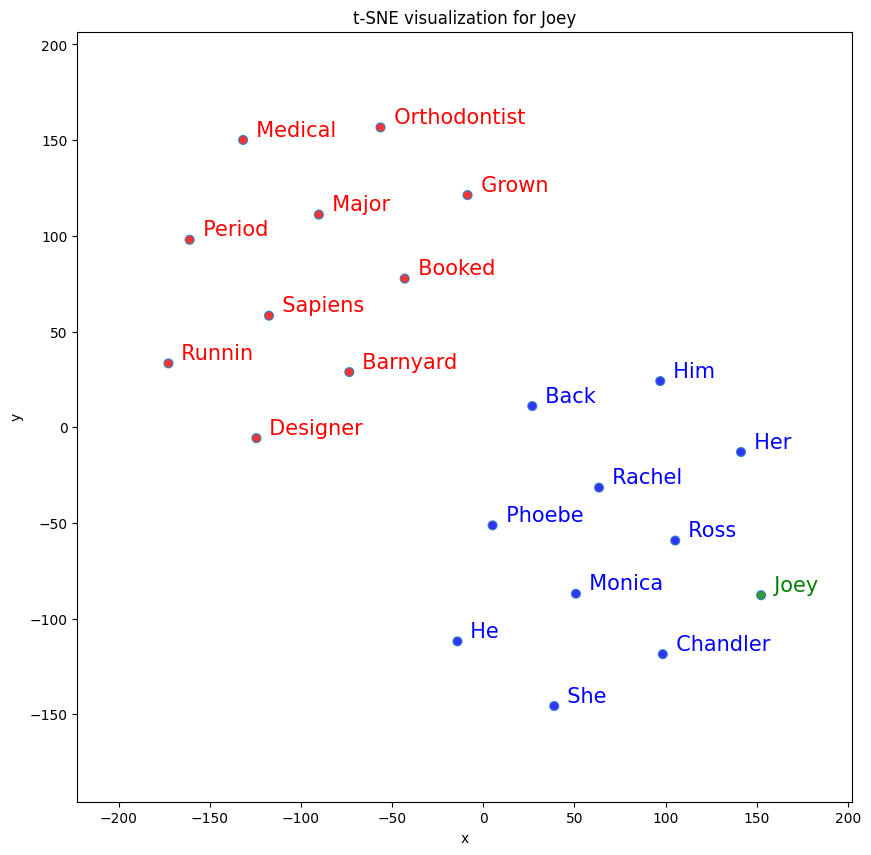

In [67]:
tsneplot(w2v, "joey")

## Task 2: Multi-class Classification (1 + 3 + 2 = 6 points)
In this task, we aim to classify consumer finance complaints into 12 pre-defined classes. Note that this is not a multi-label task, and we assume that each new complaint is assigned to one and only one category. The data comes from https://www.data.gov/ (US government’s open data) and contains complaints that are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whatever comes first.


### Sub Task 1: Data Exploration

Read the data to a pandas dataframe from `complaints.csv` (also located in the `data` folder); this is a rather large file of 206MB. Keep only the `Consumer complaint narrative` (input text) and `product` (labels). Remove the missing values, rename `Consumer complaint narrative` to `Narrative` for ease of use, and add a column encoding the product as an integer. This will represent your labels for classification and the mapping will be used later on. Create two dictionaries: one mapping the ids to products and one mapping products to their ids.

In [69]:
import pandas as pd
%matplotlib inline
df = pd.read_csv("data/complaints.csv")
df =  df.filter(["Consumer complaint narrative", "Product"])

df =  df.rename(columns = {"Consumer complaint narrative":"narrative"})
df.head()



,narrative,Product
0,NaN,Checking or savings account
1,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser..."
2,NaN,Vehicle loan or lease
3,NaN,Checking or savings account
4,NaN,Checking or savings account


In [70]:
df = df.dropna()
mapping = {item:i for i, item in enumerate(df["Product"].unique())}
df["product_id"] = df["Product"].apply(lambda x: mapping[x])
df2 = df.drop_duplicates(subset="product_id")
ids_to_product = {}
product_to_id = {}
for row in df2.index:
    ids_to_product.update({df2["product_id"][row]:df2["Product"][row]})
    product_to_id.update({df2["Product"][row]:df2["product_id"][row]})
df2



,narrative,Product,product_id
1,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser...",0
5,I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENT...,Vehicle loan or lease,1
6,My original lender was XXXX XXXX XXXX ; this l...,Student loan,2
15,Capital One mailed me a closeout check on or a...,Checking or savings account,3
34,I was stupid enough to charge some items at MA...,Credit card,4
49,Took out loan of $ XXXX..Have paid back amount...,"Payday loan, title loan, or personal loan",5
80,"On XX/XX/2016, I received a credit monitoring ...",Consumer Loan,6
594,I had a online payday loan with XXXX a few yea...,Payday loan,7
921,M & t bank customer service Claims a credit ca...,Bank account or service,8
9575,I have recently submitted a complaint with Equ...,Credit reporting,9


Look at the class distribution of the products. It is always a good idea to look at the relative number of instances for each class before performing any classification task. Use the `plot` function from the dataframe to show the number of instances in each class in a histogram.

<Figure size 1000x800 with 0 Axes>

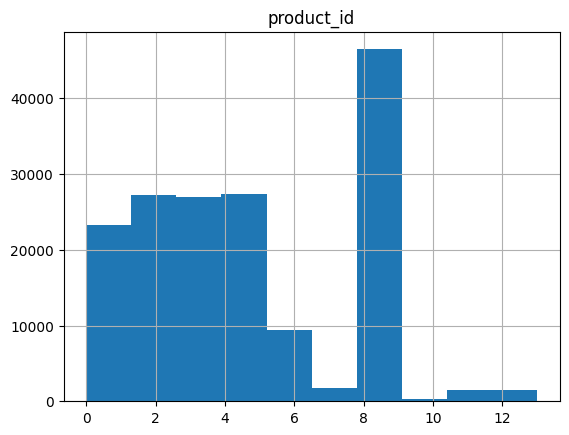

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
df.hist()
plt.show()

If you have done the exercise correctly you should observe a class imbalance with `credit reporting` having the most complaints. This can result in some difficulties for standard algorithms, making them biased towards the majority class and treating the minority classes as outliers and unimportant. One way to overcome this problem is by using **undersampling** or **oversampling**. However, this is beyond the scope of this assignment.

### Sub Task 2: Text Representation and Training the Classifier 
Before performing any classification we need to split our data into train and test sets. Use `sklearn` to save 20 percent of the data for the test and the rest for training. Make sure to input the index of the data frame to retrieve the indices of the test and train. To ensure reproducibility, use `random_state=42`.


In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df["narrative"], df["product_id"], df.index, test_size=0.2, random_state=42)

To perform any sort of classification task, we first need to convert our raw text into some vector representation. Let's use the `TfidfVectorizer` from `sklearn` to convert the `narrative` column into TF-IDF vectors. When transforming the text keep the following in mind:
- use the logarithmic form for frequency
- remove accents (ASCII) 
- lowercase all characters 
- remove `English` stop words 
- ignore terms that have a document frequency strictly less than 10
- smooth IDF weights by adding one to document frequencies 
- output row should have unit L2 norm
- set the encoding to `Latin-1`
- extract both uni-grams and bi-grams 
- build a vocabulary that only considers the top 10.000 features
Keep in mind that the vectorizer should be trained **only** on the training data, and the test data should be transformed using the same model.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents="ascii", lowercase=True, stop_words="english", min_df=10, smooth_idf=True, norm="l2", encoding="latin-1", ngram_range=(1,2), max_features=10000)
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)
X_train.shape # should be (132647, 10000) 



(132647, 10000)

After the data transformation, we attain the features and labels, to train the classifier. In our case, we use **Naive Bayes Classifier**. 
- use `MultinomialNB` from sklearn to classify the data 

In [75]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
MultinomialNB()


MultinomialNB()

### Sub Task 3: Model Evaluation  

We evaluate our model using the held-out test data. We are going to look at the confusion matrix to show the performance of the model. 

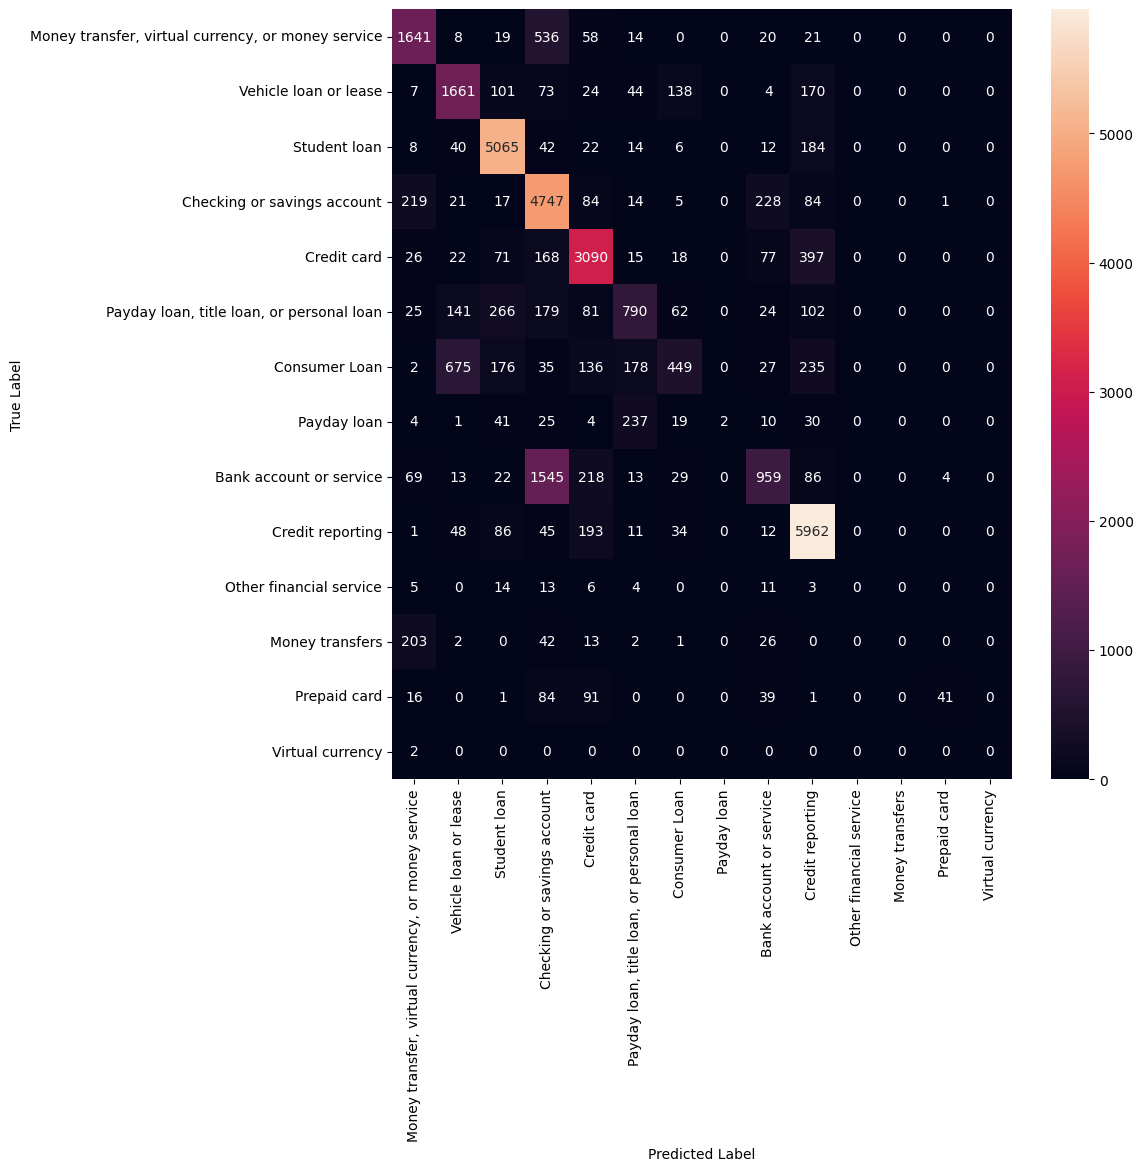

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = clf.predict(X_test)
conf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels=ids_to_product.values(),
            yticklabels=ids_to_product.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




The majority of the predictions end up on the diagonal (predicted label = actual label). The diagonal shows the correct classified classes. However, there are several misclassifications, specifically `Checking or savings account` is often confused with `Bank account or service`. Let's take a look at why this happens. For this, we look at 5 misclassified examples.

In [77]:
actual = 'Bank account or service'
predicted = 'Checking or savings account'
df = pd.DataFrame(data=X_test)
df

,0
0,"(0, 9949)\t0.19873590400994057\n (0, 9826)\..."
1,"(0, 9949)\t0.11562242324826984\n (0, 9286)\..."
2,"(0, 9949)\t0.05470076866359342\n (0, 9767)\..."
3,"(0, 4880)\t0.5744191747780663\n (0, 3920)\t..."
4,"(0, 9141)\t0.13337793162568032\n (0, 9140)\..."
...,...
33157,"(0, 9949)\t0.0771895672058162\n (0, 9906)\t..."
33158,"(0, 9949)\t0.3396083613344609\n (0, 9901)\t..."
33159,"(0, 9557)\t0.23643270903264832\n (0, 9509)\..."
33160,"(0, 9959)\t0.14612378531726722\n (0, 9958)\..."


As you can see, some of the misclassified complaints are complaints that are not easy to distinguish. 

## Task 3: Auto-Complete (2 + 5 + 4 = 11 points)
Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]

By the end of this assignment, you will develop a simple prototype of such a system using n-gram language models. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word. 

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language models by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Sub Task 1: Load and Preprocess Data 
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where tweets are separated by `\n`

In [1]:
import math
import random
import numpy as np
import spacy
from spacy.cli import download

download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])


with open("data/twitter.txt", "r") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.) 
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required, although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [2]:

def empty_spaces(sentences):
    my_list = []
    for i in sentences:
        i.strip
        my_list.append(i)
    my_list = filter(None, my_list)
    doc_sents = [sent for sent in my_list]
    return doc_sents
    


sentences = data.splitlines()
sentences = empty_spaces(sentences)



In [36]:
# list of list of the tokens in a sentence

sentences = [x.lower() for x in sentences]
tokenized_corpus = []

for x in range(len(sentences)):
    doc = nlp(sentences[x])
    tokenized_corpus.append([w.text for w in doc])
    

/Users/dabanto/miniconda3/envs/textml/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [4]:
from random import Random
from sklearn.model_selection import train_test_split
Random(4).shuffle(tokenized_corpus)

train, test = train_test_split(tokenized_corpus, test_size=0.2)



In [5]:
from collections import Counter
from nltk.util import flatten
from nltk.probability import FreqDist
flatten_train = flatten(train)
flatten_test = flatten(test)
flatten_all = flatten(tokenized_corpus)
word_counts = FreqDist(flatten_all)

vocab = []
for k, v in word_counts.items():
    if v > 2:
        vocab.append(k)

print(len(vocab)) ### should be 14930 ### 


train_replaced = []

for i, l in enumerate(train):
    for j, word in enumerate(l):
        if word not in vocab:
            train[i][j] = word.replace(word, '<unk>')
            train_replaced.append(train[i][j])
        if word in vocab:
            train_replaced.append(word)
            
test_replaced = []          
for i, l in enumerate(test):
    for j, word in enumerate(l):
        if word not in vocab:
            test[i][j] = word.replace(word, '<unk>')
            test_replaced.append(test[i][j])
        if word in vocab:
            test_replaced.append(word)


11827


### Sub Task 2: N-gram Based Language Model: 
In this section, you will develop the n-grams language model. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word 't' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will: 
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below. 

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n-gram counts (called n_gram in the code).

In [46]:
from collections import defaultdict
from collections import Counter
import nltk, re, string, collections
from nltk.util import ngrams 

def n_grams_counts(corpus, n):

    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus: 
        # convert list to tuple so it can be used a the key in the dictionary 
        sentence = tuple(sentence)
        bigrams = list(ngrams(sentence, n))
        freq= nltk.FreqDist(bigrams)
        n_grams.update(freq)

    n_grams = dct
            
        
        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count 
    return n_grams
n_grams = n_grams_counts(tokenized_corpus, 3)
n_grams

{('how', 'are', 'you'): 1,
 ('are', 'you', '?'): 1,
 ('you', '?', 'btw'): 1,
 ('?', 'btw', 'thanks'): 1,
 ('btw', 'thanks', 'for'): 1,
 ('thanks', 'for', 'the'): 1,
 ('for', 'the', 'rt'): 1,
 ('the', 'rt', '.'): 1,
 ('rt', '.', 'you'): 1,
 ('.', 'you', 'gon'): 1,
 ('you', 'gon', 'na'): 1,
 ('gon', 'na', 'be'): 1,
 ('na', 'be', 'in'): 1,
 ('be', 'in', 'dc'): 1,
 ('in', 'dc', 'anytime'): 1,
 ('dc', 'anytime', 'soon'): 1,
 ('anytime', 'soon', '?'): 1,
 ('soon', '?', 'love'): 1,
 ('?', 'love', 'to'): 1,
 ('love', 'to', 'see'): 1,
 ('to', 'see', 'you'): 1,
 ('see', 'you', '.'): 1,
 ('you', '.', 'been'): 1,
 ('.', 'been', 'way'): 1,
 ('been', 'way', ','): 1,
 ('way', ',', 'way'): 1,
 (',', 'way', 'too'): 1,
 ('way', 'too', 'long'): 1,
 ('too', 'long', '.'): 1,
 ('when', 'you', 'meet'): 1,
 ('you', 'meet', 'someone'): 1,
 ('meet', 'someone', 'special'): 1,
 ('someone', 'special', '...'): 1,
 ('special', '...', 'you'): 1,
 ('...', 'you', "'ll"): 1,
 ('you', "'ll", 'know'): 1,
 ("'ll", 'know', 

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [ ]:
def probability(word, prev_n_gram, 
                         n_gram_cnts, n_plus1_gram_cnts, vocab_size):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary
    
    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)
    
    prev_n_gram_cnt =  # get the previous n-gram count from the dictionary 
    denominator = # denominator with the previous n-gram count and k-smoothing
    n_plus1_gram =  # add the current word to the n-gram 
    n_plus1_gram_cnt =  # get the current n-gram count using the dictionary
    numerator = #calculate the numerator with k-smoothing
    prob =
    
    return prob


Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram 
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    
    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)
    
    vocab =  # add <e> <unk> to the vocabulary
    vocabulary_size = #compute the size 
    
    probabilities = {}
    for word in vocab:
        ### compute the probability 
    return probabilities


In [ ]:
 # Predict the probability of the all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)


### Sub Task 3: Evaluation 

In this part we use the perplexity score to evaluate your model on the test set.
The perplexity score of the test set on an n-gram model is defined as follows: 

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.

Notice that we have already computed this probability. 

The higher the probabilities are, the lower the perplexity will be. 

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant
    
    Returns: Perplexity score for a single sentence 
    """
    
    n =  # get the number 'n' in  n-gram  from n_gram_cnts  
    
    sentence =  # prepend <s> and append <e>
    sentence = tuple(sentence)
    N =# length of sentence 
    
   
    product_pi = 1.0 
    
    ### Compute the product of probabilites ###
    
    for t in range(n, N): 
        n_gram =# get the n-gram before the predicted word (n-gram before t )
        word =  # get the word to be predicted (position t)
        prob = probability(
        product_pi *= # Update the product of the probabilities
    
    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity


Use the function to find the perplexity of a bi-gram model on the first instance of training and test set.

In [ ]:
bigram_counts = ### your code ###
trigram_counts = ### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the preprexity for the train sample should be much lower


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n 
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word
        
    Returns: (most likely next word,  probability) 
    """    
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts     
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    
    probabs = # Estimate the probabilities for each word in the vocabulary
    
    probabs = 
    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character 


Test your model based on the bi-gram model created on the training corpus.

In [ ]:
previous_tokens = ['i', 'like']
start_with = 'g'
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


In [ ]:
previous_tokens = ['i', 'like', 'to']
start_with = None
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


In [ ]:
previous_tokens = ["hello", "my", "name", "is"]
start_with = None
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


In [ ]:
previous_tokens = ["hello", "my", "name", "is"]
start_with = 'sa'
suggestion = suggest_a_word(previous_tokens, bigram_counts,
                            trigram_counts, list(vocab), start_with=start_with)
suggestion


Decaying learning has the advantage that at the beginning of training where the model weights are usually
chosen at random, the algorithm can fastly converge towards a minimum. After more and more steps, it can be
assumed that the solution is near such a minimum, and only smaller steps are taken, such that the algorithm can 
now "fine-tune" model parameters, instead of altering weights massively, potentially stepping over the optimal
the solution again and again.

## Task 4: Model Evaluation & Comparison (1 + 2 + 2 + 2 = 7 points)

In this task we want to evaluate and compare the performance of three different imaginary spam mail classifiers. The file `spam_ham_dataset_predictions.csv` consists of a dataset of e-mails with the labels `ham (0)` and `spam (1)` which was taken over from [Kaggle](https://www.kaggle.com/code/syamkakarla/spam-mail-classifier/data). Additionally, predictions from three different models (A, B and C) were added to the dataset.

### Subtask 1: Class Distribution

We start by loading the data and looking at it first. Since we want to evaluate the performance of the given classifiers, one of the important aspects to know is how the classes are distributed within the dataset. Therefore, we extract the true distribution of classes from the gold labels as well as the predicted distributions of classes from the predicted labels of the models.

In [78]:
df = pd.read_csv("data/spam_ham_dataset_predictions.csv", index_col=0)
df



,label,text,label_num,prediction_model_A,prediction_model_B,prediction_model_C
3063,ham,"Subject: tenaska iv 12 / 00 , 2 / 01 and 3 / 0...",0,1,1,0
1661,ham,Subject: revised : eastrans nomination change ...,0,1,1,0
2816,ham,Subject: neon lesson # 5\r\nhere is the lesson...,0,1,1,0
1507,ham,Subject: cornhusker\r\ni have entered deals in...,0,1,1,0
955,ham,Subject: prior month misnomination\r\ndaren - ...,0,1,1,0
...,...,...,...,...,...,...
503,ham,Subject: 23 rd noms\r\n- - - - - - - - - - - -...,0,0,0,0
1764,ham,Subject: tenaska iv outage update\r\nfyi .\r\n...,0,0,0,0
2941,ham,Subject: me again\r\ndid you survive bid week ...,0,0,0,0
1958,ham,Subject: 6 / 4 / 99 and 6 / 9 / 99 ( 98 - 0439...,0,0,0,0


In [80]:
class_distribution = df[["label_num", 'prediction_model_A', "prediction_model_B", "prediction_model_C"]]

# renaming the rows for a nicer table and plot
class_distribution = class_distribution.rename(columns={
    "label_num": "Gold Labels",
    "prediction_model_A": "Model A",
    "prediction_model_B": "Model B",
    "prediction_model_C": "Model C"
})

# display the class distribution table
class_distribution




,Gold Labels,Model A,Model B,Model C
3063,0,1,1,0
1661,0,1,1,0
2816,0,1,1,0
1507,0,1,1,0
955,0,1,1,0
...,...,...,...,...
503,0,0,0,0
1764,0,0,0,0
2941,0,0,0,0
1958,0,0,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


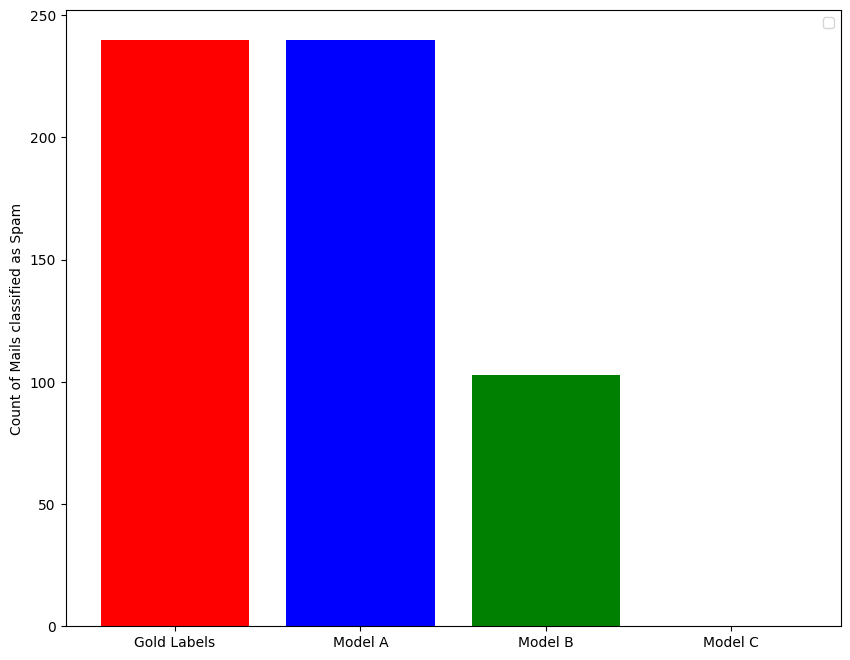

In [81]:


%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
kwargs = dict(alpha=0.5, bins=100)
plt.bar(x="Gold Labels", height=class_distribution["Gold Labels"].sum(), color='r')
plt.bar(x="Model A",height=class_distribution["Gold Labels"].sum(), color='b')
plt.bar(x="Model B", height=class_distribution["Model B"].sum(), color='g')
plt.bar(x="Model C", height=class_distribution["Model C"].sum(), color='g')
plt.gca().set(ylabel='Count of Mails classified as Spam')
plt.legend()
plt.show()



You should see that the distribution of classes in the dataset is very unbalanced. There are far more "ham" mails than spam mails in the dataset. Model A comes closest to the real distribution, while Model B predicts even fewer spam mails than actually exist. An extreme case is Model C, which classifies all mails as unproblematic "ham" mails and assumes no spam mails in the data set.

Obviously, based on the predicted distributions, we cannot yet estimate how many labels were actually predicted correctly. Therefore, we calculate this in the next step.

### Sub Task 2: Accuracy

To see which model made the most correct predictions, we want to calculate the accuracy in the next step. In general, the metric of the accuracy is defined as follows:
$$
\text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}}\\
$$.

In the case of binary classification, the accuracy can be calculated as follows:
$$
\begin{align*}
\text{Accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}\\
\text{Accuracy} &= \frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{false positives} + \text{true negatives} + \text{false negatives}}\\
\end{align*}
$$

First, define methods that return TP, TN, FP and FN for a given model from the DataFrame.

In [82]:
def true_positives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    res = 0
    df = df[[prediction_column, gold_label_column]]
    for ind in df.index:
        if df[prediction_column][ind] == 1 and df[gold_label_column][ind] == 1:
            res += 1
    return res

def true_negatives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    res = 0
    for ind in df.index:
        if df[prediction_column][ind] == 0 and df[gold_label_column][ind] == 0:
            res += 1
    return res

def false_positives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    res = 0
    for ind in df.index:
        if df[prediction_column][ind] == 1 and df[gold_label_column][ind] == 0:
            res += 1
    return res

def false_negatives(df: pd.DataFrame, prediction_column: str, gold_label_column: str = "label_num") -> int:
    res = 0
    for ind in df.index:
        if df[prediction_column][ind] == 0 and df[gold_label_column][ind] == 1:
            res += 1
    return res



Now define the method for calculating the accuracy using parameters for the values for TP, TN, FP and FN.

In [83]:
def accuracy(tp: int, tn: int, fp: int, fn: int) -> float:
    return (tp + tn) / (tp + tn + fp + fn)



After having defined the methods, we can now calculate the accuracy for each model. To be able to reuse the calculated values and additionally depict them in a DataFrame, we store the results in a dictionary. 

In [84]:
# dictionary for storing all results
evaluation_results = {}

for model in ["A", "B", "C"]:
    # column with the predicted labels from the model in the df
    prediction_column = f"prediction_model_{model}"

    # save TP, FP, TN and FN for this model
    evaluation_results[model] = {
        "TP":true_positives(df, prediction_column),
        "FP":false_positives(df, prediction_column),
        "TN":true_negatives(df, prediction_column),
        "FN":false_negatives(df, prediction_column),
    }
    # save accuracy for this model
    evaluation_results[model]["accuracy"] = accuracy(evaluation_results[model]["TP"], evaluation_results[model]["TN"], evaluation_results[model]["FP"], evaluation_results[model]["FN"])

# create a temporary DataFrame for displaying the results in a table
pd.DataFrame(evaluation_results)

,A,B,C
TP,48.000000,30.000000,0.00000
FP,183.000000,73.000000,0.00000
TN,3489.000000,3599.000000,3672.00000
FN,192.000000,210.000000,240.00000
accuracy,0.904141,0.927658,0.93865


You should see that all models have a very high accuracy. This can be explained by the uneven distribution of the data, which is roughly reflected by all models.

We also see that Model C has the highest accuracy and is therefore the best classifier according to this metric. However, since Model C does not recognize spam mails at all, but classifies all mails as "ham", this model will not add any value in practice. The use of the model would have no effect.

Therefore, in the next step we want to look at other metrics with which we can compare the classifiers.

### Sub Task 3: Precision, Recall, F-measure

Two very commonly used metrics for evaluating classifiers are precision and recall. 

Precision measures the percentage of the items that the classifier detected as positive that are actually positive according to the gold labels. Precision is defined as follows:
$$
\text{Precision (\textit{P})} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

Recall measures the percentage of positive items that the classifier was able to detect as positive. Recall is defined as follows:
$$
\text{Recall (\textit{R})} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$


First we will define methods to calculate precision and recall based on the required parameters.

In [86]:
def precision(tp:int, fp:int) -> float:
    return tp / (tp+fp)

In [85]:
def recall(tp:int, fn:int) -> float:
    return tp / (tp + fn)



Now we can calculate precision and recall for the classifiers to see which classifier performs better overall.

*Note*: Since we know that Model C does not generate true positives, both recall and precision will be 0. Besides, we already determined that the model is unsuitable for application. Therefore, we can exclude the model from the following calculations.

In [87]:
# exclude Model C from the following calculations
evaluation_results.pop("C", None)

for model in evaluation_results:
    # save precision and recall for this model
    evaluation_results[model]["precision"] = precision(evaluation_results[model]["TP"], evaluation_results[model]["FP"])
    evaluation_results[model]["recall"] = recall(evaluation_results[model]["TP"], evaluation_results[model]["FN"])

pd.DataFrame(evaluation_results)



,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000


The calculations should show that Model B has a significantly higher precision than Model A. However, Model A has a higher recall. Thus, we cannot easily decide which model is better. Therefore, we want to combine the two metrics in order to be able to compare the classifiers on the basis of a single value.

One frequently used combination of precision and recall is the F-score. The F-Score is defined as follows:
$$
F_\beta = \frac{(\beta^2 + 1) P R}{\beta^2 P + R}
$$
The $\beta$ parameter in the formula can be used to weight the importance between precision and recall.

The most commonly used value for $\beta$ is $1$. The resulting metric is called $F_1$ score.
$$
F_1 = \frac{2 P R}{P + R}
$$

Let us define a method to calculate the F-score based on the required parameters at first.

In [88]:
def f_beta(tp:int, fp:int, fn:int) -> float:
    return (2 * precision(tp,fp) * recall(tp,fn)) / (precision(tp, fp) + recall(tp, fn))



Now we want to calculate the $F_1$ score for the classifiers to see which one performs better overall. 

In [89]:
for model in evaluation_results:
    # save the F_1 score for this model
    evaluation_results[model]["F_1"] = f_beta(evaluation_results[model]["TP"], evaluation_results[model]["FP"], evaluation_results[model]["FN"])

pd.DataFrame(evaluation_results)




,A,B
TP,48.000000,30.000000
FP,183.000000,73.000000
TN,3489.000000,3599.000000
FN,192.000000,210.000000
accuracy,0.904141,0.927658
precision,0.207792,0.291262
recall,0.200000,0.125000
F_1,0.203822,0.174927


After correct calculation you should see that the $F_1$ score of Model A is higher than that of Model B. Accordingly, Model A is the better classifier if we want to weight precision and recall equally.

### Sub Task 4: Adapting the metric to the use case

Let's not stop at that point. Is Model A really better for spam detection than Model B?

Consider why Model B might be better than Model A for the spam detection use case in practice. Consider how the metric could be easily adapted for the purpose of spam detection. 

Calculate an adjusted metric for the models and briefly explain the adjustment and the result.

In [90]:
for model in evaluation_results:
    evaluation_results[model][### metric name ###] = ### your code ###

pd.DataFrame(evaluation_results)




SyntaxError: incomplete input (1780566255.py, line 6)

**Your brief explanation:** 
